In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Attention,Dense, Conv1D, Convolution2D, GRU, LSTM, Bidirectional, TimeDistributed,
                          Dropout, Flatten, LayerNormalization,RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import linear_model
import pandas as pd
import torch
import torch.nn as nn
import random
#from keras import layers as layers
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from scipy import special
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras_self_attention import SeqSelfAttention

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.decomposition import NMF
from scipy import io
import numpy as np
import os
import os.path



In [3]:
cd Revealing-Ferroelectric-Switching-Character-Using-Deep-Recurrent-Neural-Networks/

/Users/qinshuyu/497_MAT_Assignment/Revealing-Ferroelectric-Switching-Character-Using-Deep-Recurrent-Neural-Networks


In [4]:
import warnings
warnings.filterwarnings('ignore')
import imp
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import codes.analysis.rnn as rnn
import codes.util as util
import codes.analysis.machine_learning as ml
import codes.analysis as an
import codes.processing as p
import codes.viz as viz
import codes.util.input_output as io_transfer

Using TensorFlow backend.


In [5]:
imported = {'data': io.matlab.loadmat('./Raw_Data/Data.mat'),
            'validation_data': io.matlab.loadmat('Raw_Data/loop_1.mat')}

# extracts the important information from the raw data
raw = {'voltage': imported['data']['Voltagedata_mixed'],
       'piezoresponse': imported['data']['Loopdata_mixed'],
       'amplitude': imported['data']['OutA2_mixed'],
       'phase': imported['data']['OutPhi1_mixed'],
       'resonance': imported['data']['Outw2_mixed'],
       'quality_factor': imported['data']['OutQ2_mixed'],
       'val_piezoresponse': imported['validation_data']['piezo_1'],
       'val_resonance': imported['validation_data']['resonance_loop_1']}

In [6]:
p.filters.range_filter(raw['resonance'], [1300, 1340])
p.filters.range_filter(raw['val_resonance'], [1300, 1340])

# interpolates data that is non-real. This happens when the SHO fit fails
interpolated = {'voltage': raw['voltage'],
                'piezoresponse': p.filters.clean_interpolate(raw['piezoresponse'],
                                                             'linear').reshape(-1, raw['piezoresponse'].shape[2]),
                'amplitude': p.filters.clean_interpolate(raw['amplitude'],
                                                         'linear').reshape(-1, raw['amplitude'].shape[2]),
                'phase': p.filters.clean_interpolate(raw['phase'],
                                                     'linear').reshape(-1, raw['phase'].shape[2]),
                'resonance': p.filters.clean_interpolate(raw['resonance'],
                                                         'linear').reshape(-1, raw['resonance'].shape[2]),
                'quality_factor': p.filters.clean_interpolate(raw['quality_factor'],
                                                              'linear').reshape(-1, raw['quality_factor'].shape[2]),
                'val_piezoresponse': p.filters.clean_interpolate(raw['val_piezoresponse'],
                                                                  'linear').reshape(-1, raw['val_piezoresponse'].shape[2]),
                'val_resonance': p.filters.clean_interpolate(raw['val_resonance'],
                                                             'linear').reshape(-1, raw['val_resonance'].shape[2])}
# Uses Savitzky-Golay filter to remove outlier points
sg_filtered = {'voltage': raw['voltage'],
               'piezoresponse': p.filters.savgol(interpolated['piezoresponse'], fit_type='linear'),
               'amplitude': p.filters.savgol(interpolated['amplitude'], fit_type='linear'),
               'phase': p.filters.savgol(interpolated['phase'], fit_type='linear'),
               'resonance': p.filters.savgol(interpolated['resonance'], fit_type='linear'),
               'quality_factor': p.filters.savgol(interpolated['quality_factor'], fit_type='linear'),
               'val_piezoresponse': p.filters.savgol(interpolated['val_piezoresponse'], fit_type='linear'),
               'val_resonance': p.filters.savgol(interpolated['val_resonance'], fit_type='linear')}

# normalized the data. This is important for training Neural Networks
normalized = {'voltage': raw['voltage'],
              'piezoresponse': p.filters.normalize(sg_filtered['piezoresponse']),
              'amplitude': p.filters.normalize(sg_filtered['amplitude']),
              'phase': p.filters.normalize(sg_filtered['phase']),
              'resonance': p.filters.normalize(sg_filtered['resonance']),
              'quality_factor': p.filters.normalize(sg_filtered['quality_factor']),
              'val_piezoresponse': p.filters.normalize(sg_filtered['val_piezoresponse'],
                                                       sg_filtered['piezoresponse']),
              'val_resonance': p.filters.normalize(sg_filtered['val_resonance'],
                                                   sg_filtered['resonance'])}

In [7]:
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
scipy: 1.4.1
numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
sklearn: 0.22.1


In [8]:
X = np.atleast_3d(normalized['piezoresponse'])
Y = np.atleast_3d(normalized['val_piezoresponse'])

In [9]:
V = normalized['voltage']

In [10]:
# builds folders where the data will be saved
folder_structure = util.file.make_folder(
    './structure')
folder_BE = util.file.make_folder(
    './Band_Excitation')
folder_BE_Movie_files = util.file.make_folder(
    folder_BE + '/BE_Movie_Files')
folder_BE_all_images = util.file.make_folder(
    folder_BE + '/BE_all_images')
folder_BE_spectra = util.file.make_folder(
    folder_BE + '/BE_spectra')
folder_BE_cleaned_spectra = util.file.make_folder(
    folder_BE + '/cleaned_spectra')
folder_pca = util.file.make_folder(
    './pca')
folder_nmf = util.file.make_folder(
    './nmf')
folder_clustering = util.file.make_folder('./clustering')
folder_pca_clustering = util.file.make_folder(
    './pca_clustering')
folder_piezoresponse_autoencoder = util.file.make_folder(
    './piezoresponse_autoencoder')
folder_resonance_autoencoder = util.file.make_folder(
    './resonance_autoencoder')
folder_piezoresponse_autoencoder_movie = util.file.make_folder(
    folder_piezoresponse_autoencoder + '/movie')
folder_piezoresponse_autoencoder_training_movie = util.file.make_folder(
    folder_piezoresponse_autoencoder + '/training_movie')
folder_resonance_autoencoder_movie = util.file.make_folder(
    folder_resonance_autoencoder + '/movie')
folder_resonance_autoencoder_training_movie = util.file.make_folder(
    folder_resonance_autoencoder + '/training_movie')
folder_phase_field = util.file.make_folder(
    './Phase_Field')

In [69]:
plot_format = {
    # adds scalebar to image
    'add_scalebar': True,
    # sets the dimensions for the scalebar [(size of image),(size of scalebar)]
    'scalebar': [2000, 500],
    # selects if the image will be rotated
    'rotation': False,
    # selects the rotation angle of the image
    'angle': 60.46,
    # sets the fraction of the image to crop
    'frac_rm': 0.17765042979942694,
    # sets the resolution of the image
    'dpi': 300,
    # sets the default colormap
    'color_map': 'viridis',
    # sets if color bars should be added
    'color_bars': True}

In [12]:
cd ..

/Users/qinshuyu/497_MAT_Assignment


In [54]:
piezoresponse_model = load_model('Washington_mall_5100.h5')

In [71]:
# Sets what object to export
printing = {  # exports eps vector graphics (note these files can be large)
    'EPS': False,
    # exports png files
    'PNG': True,
    # prints image series (note this can take some time)
    'all_figures': False,
    # generates movies (note this can take some time)
    'movies': False,
    # resolution of the images
    'dpi': 300}

In [15]:
from libtiff import TIFF

In [16]:
tif = TIFF.open('Washington_DC_Mall.tif', mode='r')

In [17]:
image1 = tif.read_image()

In [18]:
image_new = image1[0:190]

In [19]:
image_new = image_new.reshape(190,392960)

In [20]:
transposeX = np.transpose(image_new,(1,0))

In [21]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
washington_norm = scaler.fit_transform(transposeX)

In [23]:
washington_norm = transposeX.reshape(392960,190,1)

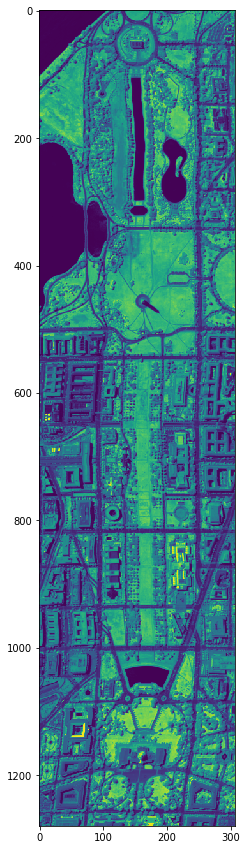

In [24]:
plt.figure(figsize=(20,15))
plt.imshow(np.transpose(washington_norm,(1,0,2))[77].reshape(1280,307))

In [25]:
new_norm = washington_norm[0:9824]

In [29]:
new_norm1 = washington_norm[9824:19648]

In [26]:
new_norm.shape

(9824, 190, 1)

In [30]:
piezoresponse_embeddings = rnn.get_activations(piezoresponse_model,
                                               new_norm,
                                               93)

In [ ]:
piezoresponse_embedding1 = rnn.get_activations(piezoresponse_model,
                                               new_norm1,
                                               93)

In [55]:
new_numpy = np.append(piezoresponse_embeddings,piezoresponse_embedding1)

In [44]:
new_numpy = new_numpy.reshape(19648,19)

In [57]:
just_try = np.append(new_numpy,piezoresponse_embeddings)

In [58]:
just_try.reshape(29472,19)[9100]

array([0.        , 0.07868659, 0.        , 0.04400108, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35746405,
       0.        , 0.1351085 , 0.39309993, 0.64237446, 0.        ,
       0.        , 0.4728867 , 0.33743897, 0.33080932], dtype=float32)

In [60]:
new_numpy.shape

(373312,)

In [67]:
piezoresponse_embeddings.shape

(9824, 19)

In [61]:
for i in range(38):
    new_data = washington_norm[9824*(i+2):9824*(i+3)]
    piezoresponse_embedding_ = rnn.get_activations(piezoresponse_model,
                                               new_data,
                                               93)
    new_numpy = np.append(new_numpy,piezoresponse_embedding_)

In [ ]:
piezoresponse_embeddings = rnn.get_activations(piezoresponse_model,
                                               washington_norm,
                                               93)

ValueError: cannot reshape array of size 9824 into shape (99,99)

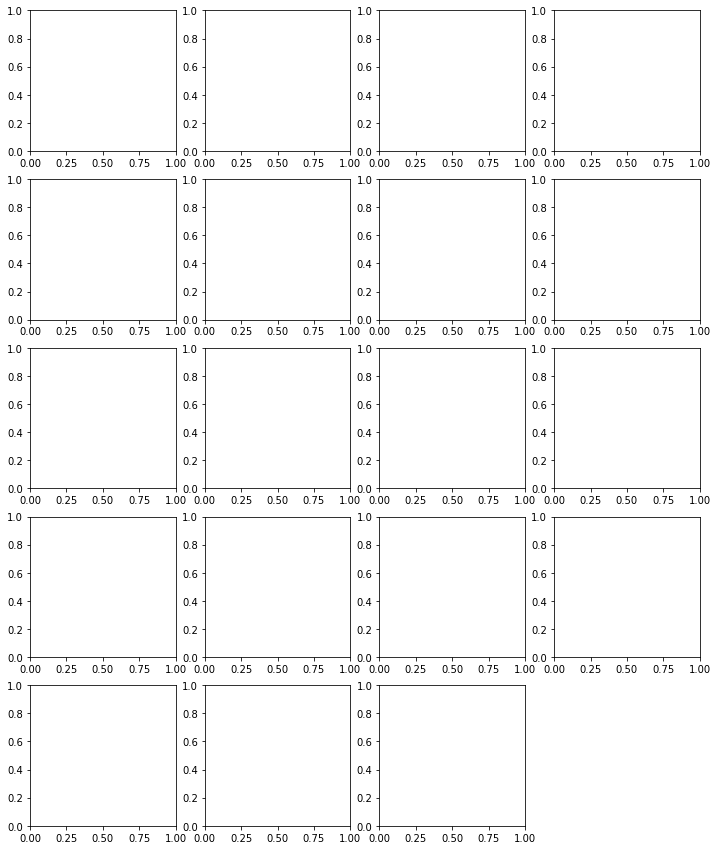

In [70]:
# plots the embedding maps
_ = viz.plot.embedding_maps(piezoresponse_embeddings,
                            printing,
                            plot_format,
                            folder_piezoresponse_autoencoder,
                            filename='./wanshing_mall_5100')

In [63]:
zhongyu = new_numpy.reshape(392960,19)

In [65]:
np.save('washington_embedding',zhongyu)

In [72]:
zhongyu[1000]

array([0.        , 0.05952026, 0.        , 0.04769902, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6584608 ,
       0.        , 0.15796083, 0.53049505, 0.6064022 , 0.        ,
       0.        , 0.43987778, 0.18398711, 0.0905938 ], dtype=float32)

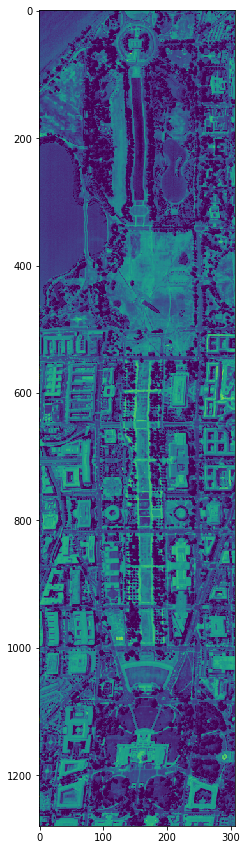

In [74]:
plt.figure(figsize=(20,15))
plt.imshow(zhongyu[:,1].reshape(1280,307))

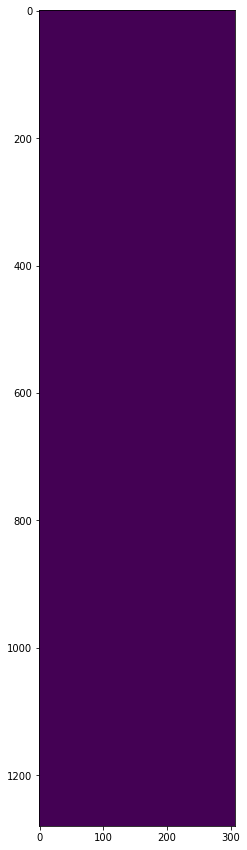

In [75]:
plt.figure(figsize=(20,15))
plt.imshow(zhongyu[:,0].reshape(1280,307))

In [79]:
def layout_fig(graph, mod=None):
    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

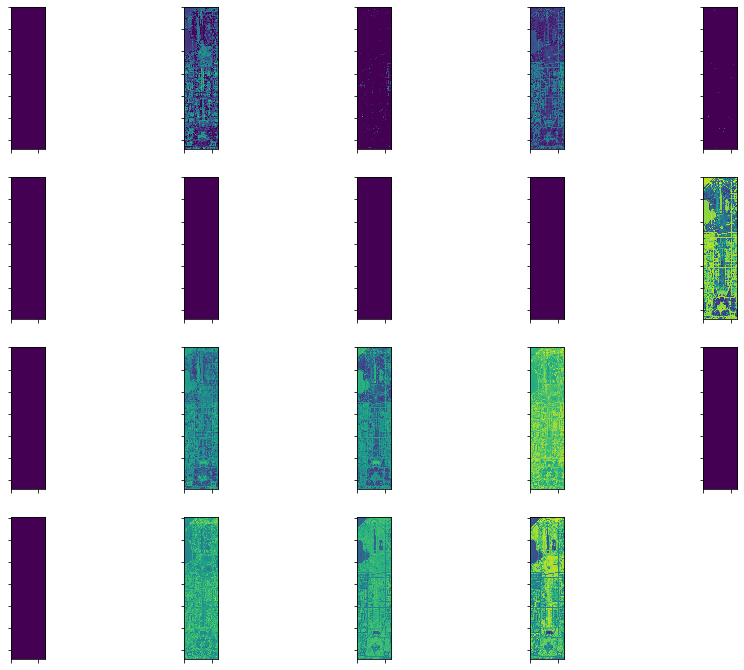

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

<Figure size 14400x10800 with 0 Axes>

In [85]:
fig, ax = layout_fig(19, mod=5)
for i in range(19):
        plt.figure(figsize=(200,150))
        if plot_format['rotation']:
            image, scalefactor = rotate_and_crop(zhongyu[:, i].reshape(original_size, original_size),
                                                 angle=plot_format['angle'], frac_rm=plot_format['frac_rm'])
        else:
            image = zhongyu[:, i].reshape(1280, 307)
            scalefactor = 1
        im = ax[i].imshow(image)
        ax[i].set_yticklabels('')
        ax[i].set_xticklabels('')